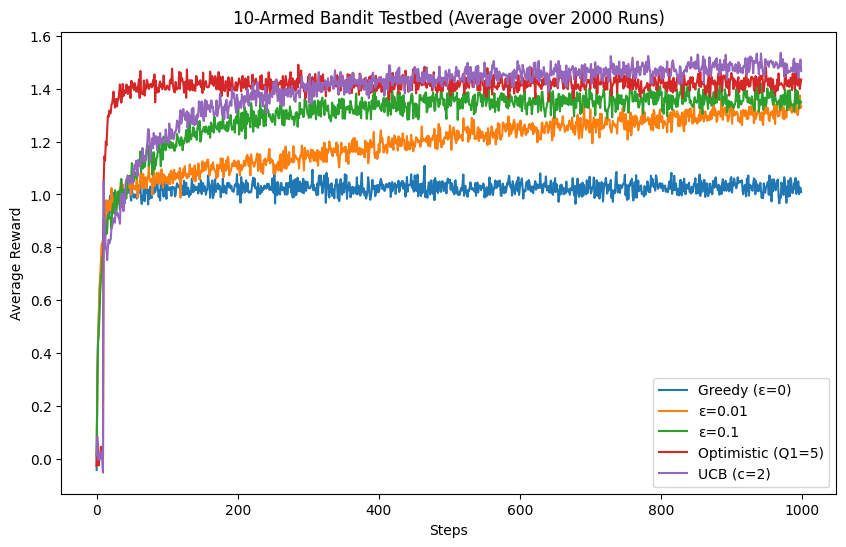

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Bandit Environment


class Bandit:
    def __init__(self, k=10):
        self.k = k
        self.q_star = np.random.normal(0, 1, k)  # true action values

    def step(self, action):
        reward = np.random.normal(self.q_star[action], 1)
        return reward



# 2. Agent Class

class Agent:
    def __init__(self, k=10, epsilon=0.0, initial=0.0, ucb=False, c=2):
        self.k = k
        self.epsilon = epsilon
        self.initial = initial
        self.ucb = ucb
        self.c = c
        self.reset()

    def reset(self):
        self.Q = np.ones(self.k) * self.initial
        self.N = np.zeros(self.k)
        self.t = 0

    def select_action(self):
        self.t += 1

        # UCB strategy
        if self.ucb:
            ucb_values = self.Q + self.c * np.sqrt(
                np.log(self.t + 1) / (self.N + 1e-5)
            )
            return np.argmax(ucb_values)

        # ε-greedy
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.k)
        else:
            return np.argmax(self.Q)

    def update(self, action, reward):
        self.N[action] += 1
        self.Q[action] += (1 / self.N[action]) * (reward - self.Q[action])



# 3. Experiment Setup


def run_experiment(runs=2000, steps=1000):

    strategies = {
        "Greedy (ε=0)": Agent(epsilon=0.0),
        "ε=0.01": Agent(epsilon=0.01),
        "ε=0.1": Agent(epsilon=0.1),
        "Optimistic (Q1=5)": Agent(epsilon=0.0, initial=5.0),
        "UCB (c=2)": Agent(ucb=True, c=2),
    }

    rewards = {name: np.zeros(steps) for name in strategies}

    for _ in range(runs):
        bandit = Bandit()

        for agent in strategies.values():
            agent.reset()

        for t in range(steps):
            for name, agent in strategies.items():
                action = agent.select_action()
                reward = bandit.step(action)
                agent.update(action, reward)
                rewards[name][t] += reward

    for name in rewards:
        rewards[name] /= runs

    return rewards



# 4. Run and Plot


results = run_experiment()

plt.figure(figsize=(10, 6))
for name, avg_rewards in results.items():
    plt.plot(avg_rewards, label=name)

plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title("10-Armed Bandit Testbed (Average over 2000 Runs)")
plt.legend()
plt.show()

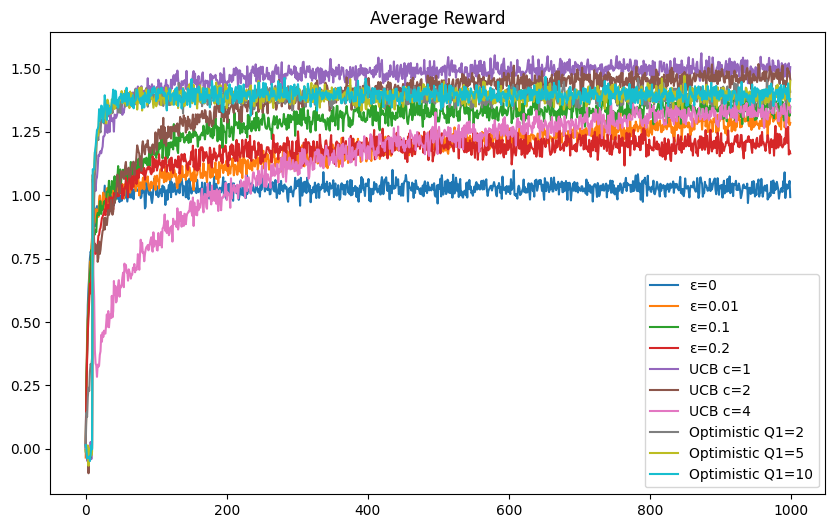

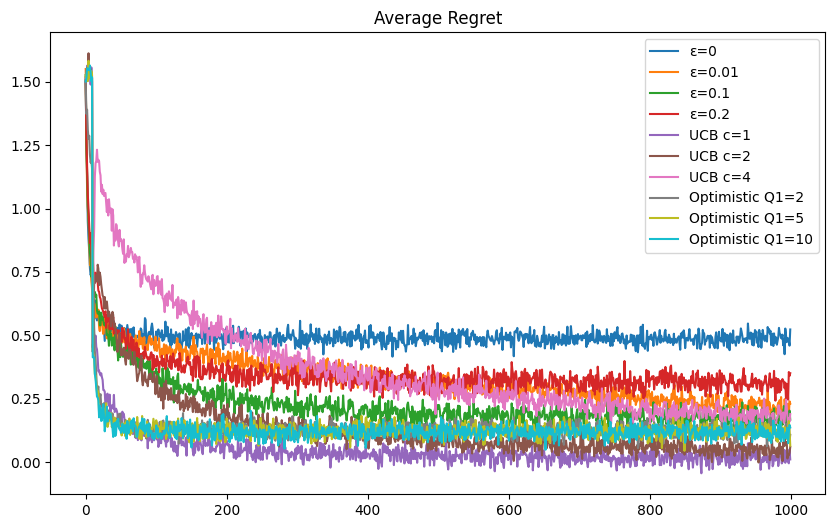

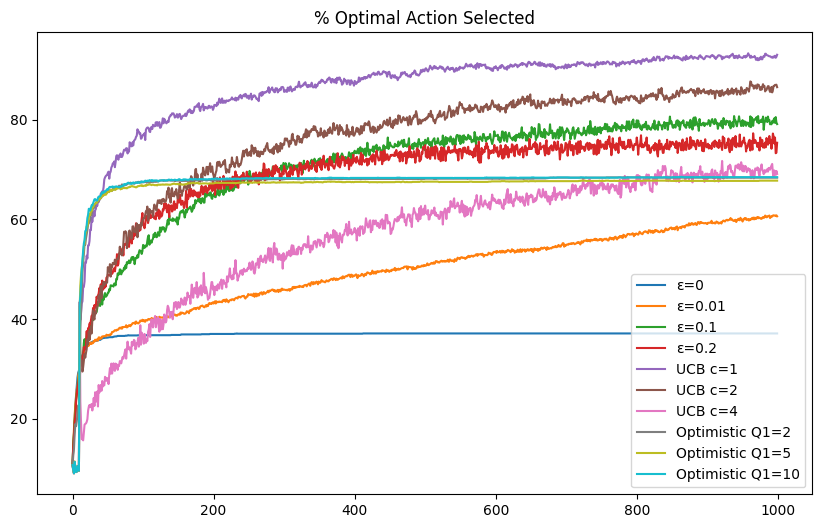

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Bandit Environment


class Bandit:
    def __init__(self, k=10):
       self.k = k
        self.q_star = np.random.normal(0, 1, k)
        self.optimal_action = np.argmax(self.q_star)

    def step(self, action):
        reward = np.random.normal(self.q_star[action], 1)
        return reward


# Agent


class Agent:
    def __init__(self, k=10, epsilon=0.0, initial=0.0, ucb=False, c=2):
        self.k = k
        self.epsilon = epsilon
        self.initial = initial
        self.ucb = ucb
        self.c = c
        self.reset()

    def reset(self):
        self.Q = np.ones(self.k) * self.initial
        self.N = np.zeros(self.k)
        self.t = 0

    def select_action(self):
        self.t += 1

        if self.ucb:
            # Force each action to be tried once
            if 0 in self.N:
                return np.argmin(self.N)

            ucb_values = self.Q + self.c * np.sqrt(
                np.log(self.t) / self.N
            )
            return np.argmax(ucb_values)

        if np.random.rand() < self.epsilon:
            return np.random.randint(self.k)
        else:
            return np.argmax(self.Q)

    def update(self, action, reward):
        self.N[action] += 1
        self.Q[action] += (1 / self.N[action]) * (reward - self.Q[action])



# Experiment


def run_experiment(agents_dict, runs=2000, steps=1000):

    avg_reward = {name: np.zeros(steps) for name in agents_dict}
    avg_regret = {name: np.zeros(steps) for name in agents_dict}
    optimal_action_percent = {name: np.zeros(steps) for name in agents_dict}

    for _ in range(runs):

        bandit = Bandit()

        for agent in agents_dict.values():
            agent.reset()

        for t in range(steps):
            for name, agent in agents_dict.items():

                action = agent.select_action()
                reward = bandit.step(action)

                agent.update(action, reward)

                # Reward tracking
                avg_reward[name][t] += reward

                # Regret tracking
                optimal_value = bandit.q_star[bandit.optimal_action]
                regret = optimal_value - reward
                avg_regret[name][t] += regret

                # Optimal action %
                if action == bandit.optimal_action:
                    optimal_action_percent[name][t] += 1

    # Average over runs
    for name in agents_dict:
        avg_reward[name] /= runs
        avg_regret[name] /= runs
        optimal_action_percent[name] = (
            optimal_action_percent[name] / runs * 100
        )

    return avg_reward, avg_regret, optimal_action_percent



# Define Strategy Variations


agents = {}

# Epsilon variations
for eps in [0, 0.01, 0.1, 0.2]:
    agents[f"ε={eps}"] = Agent(epsilon=eps)

# UCB variations
for c in [1, 2, 4]:
    agents[f"UCB c={c}"] = Agent(ucb=True, c=c)

# Optimistic variations
for init in [2, 5, 10]:
    agents[f"Optimistic Q1={init}"] = Agent(initial=init)


# Run


avg_reward, avg_regret, optimal_percent = run_experiment(agents)



# Plot Average Reward


plt.figure(figsize=(10,6))
for name, values in avg_reward.items():
    plt.plot(values, label=name)
plt.title("Average Reward")
plt.legend()
plt.show()



# Plot Regret


plt.figure(figsize=(10,6))
for name, values in avg_regret.items():
    plt.plot(values, label=name)
plt.title("Average Regret")
plt.legend()
plt.show()



# Plot % Optimal Action


plt.figure(figsize=(10,6))
for name, values in optimal_percent.items():
    plt.plot(values, label=name)
plt.title("% Optimal Action Selected")
plt.legend()
plt.show()